Notebook dedicado a la realización de una red neuronal que sea capaz de copiar la función de similitud de Wilcoxon, con el objetivo de poder determinar que pares de señales son estadísticamente iguales y cuales no. El objetivo es que esta red neuronal trabaje en el espacio latente generado por el encoder del alguno de los autoencoder que ya se han desarrollado. De esta manera se pretende evaluar la similitud entre señales en el espacio latente.

In [2]:
###Importamos las bibliotecas necesarias:
##TensorFlow, Keras a partir de TensorFlow; y de Keras además importamos el comando para crear capas
import tensorflow as tf #Importamos TensorFlow
#import tensorflow_hub as hub #Importamos esta libreria que contiene modelos preentrenados para poder importarlos
from tensorflow import keras #Importamos keras desde TensorFlow
from tensorflow.keras import layers #Importamos la funcion para crear capas de redes neuronales desde keras
from tensorflow.keras.models import Model #Importamis la clase Model de tensorflow, lo que permite crear modelos de DL como clases, con arquitecturas más complejas que usar Sequential
from tensorflow.keras.callbacks import EarlyStopping #Importamos la funcion para realizar el earlystopping desde la libreria de callbacks de keras
from tensorflow.keras.models import load_model #Cargamos la funcion para poder importar modelos de machine learning
from tensorflow.keras.utils import plot_model #Cargamos la funcion para poder realizar representaciones de la arquitectura de modelos
from keras.saving import register_keras_serializable #Funcion de queras necesaria para guardar modelos que se hayan definidos como clases

##Importamos keras tuning para poder optimizar los hiperparametros del modelo
import keras_tuner as kt

##Importamos cuda para poder liberar el espacio de la GPU
from numba import cuda

##Importamos Pandas para trabajar con DataFrames
import pandas as pd

##Importamos Numpy para incluir mas funciones matematicas
import numpy as np

##Importamos la lireria itertools para tener herramientas de iteracion sobre diferentes conjuntos
import itertools

##Importamos MatPlotLib para realizar representaciones
import matplotlib.pyplot as plt
from matplotlib import gridspec #Es un paquete de matplotlib que permite realizar figuras de varias subfiguras

##Importamos la funcion display de la libreria IPython.display, que permite mostrar contenido de manera mas enriquecida. Tambien importamos Image para poder mostrar gráficos
from IPython.display import display
from IPython.display import Image

##Importamos varias funciones de las librerias sklearn
from sklearn.model_selection import train_test_split #Es una función que se utiliza para dividir un conjunto de datos en conjuntos de entrenamiento y prueba de forma aleatoria.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #Funciones para evaluar el rendimiento de modelos de clasificcacion: accuracy_score() fraccion de muestras clasificadas correctaente (precision del modelo), precision_score() precision para una clase en particular, recall_score() sensibilidad para cada clase (tasa de verdaderos positivos)
from sklearn.metrics.pairwise import cosine_similarity #Importamos la función necesaria para calcular la similaridad coseno
from sklearn.metrics import roc_curve, roc_auc_score #Imoprtamos las funciones necesarias para poder realizar el cálculo de la curva ROC

##Importamos la función para realizar el submuestreo aleatorio de la clase mayoritaria de la biblioteca imbalance-learning
from imblearn.under_sampling import RandomUnderSampler

#Importamos la libreria joblib para poder cargar modelos generados con scikit-learn como puede ser una PCA
import joblib

##Importamos el modulo time para poder medir el tiempo de ejecución del codigo
import time

##Immportamos el generador de números aleatorios
import random

##Importamos la biblioteca os para poder configurar la sesion de tensorflow
import os

##Importamos la librería multiprocessing para poder paralelizar el computo entre los distintos núcleos de la CPU
import multiprocessing as mp

##Importamos archivos .py propios que contienen los diferentes modelo que deseamos utilizar 
import sys
sys.path.append('Digiopt/') #Es necesario agregar esta linea para que "import" busque por defecto dentro del directorio que se especifica
from AGATALib import modelos #Archivo .py que contiene los diferentes modelos que hemos creado
from AGATALib import testwcore #Archivo .py que contiene la implemenación del algoritmo de comparacion basado en el test de Wilcoxon

Inicio de la sesión de Tensorflow para limitar la memoria de la GPU usada.

In [3]:
##Funcion para establecer la sesion de tensorflow de tal manera que solo use un tercio de la memoria de la GPU. Siempre ejecutar esta celda
def set_tf_session(gpu_memory = 0.20):
    #Establecemos la fraccion de memoria de GPU a utilizar en la sesion. Por defecto emplea el 100%
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = gpu_memory)
    #Iniciamos la sesión de tensorflow con la fracción de memoria que hemos establecido
    sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))
    return sess

#Iniciamos la sesion con la fraccion de memoria deseada de GPU
set_tf_session()

2024-07-19 07:02:16.378690: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4831 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6


Definimos una serie de funciones que pueden ser últiles a lo largo del desarrollo y evaluación de la red neuronal: función para representar los pulsos, función para determinar el tiempo de ejecución, función para normalizar los datos a las escala [0,1], función para convertier en un tensor de Tensorflow un DataFrame de Pandas de tal manera que se encuentren en el formato requerido por Tensorflow y la función para pintar las estadísticas de la clasificación.

In [4]:
##Definimos una funcion para representar de manera comoda dos señales diferentes aleatorias en un mismo grafico, que provengan del mismo conjunto de datos
def plot_pulsos(data):
    #Generar dos números enteros aleatorios entre 1 y 1708
    n_random = random.randint(1, data.shape[0])
    m_random = random.randint(1, data.shape[0])
    
    #Representacion de las señales en un plot
    plt.figure(figsize = (10, 5))
    plt.plot(data.iloc[n_random], label = "Señal 1", color = "blue")
    plt.plot(data.iloc[m_random], label = "Señal 2", color = "red")
    plt.title('Señal')
    plt.xticks([])
    plt.ylabel('Valor')
    plt.show()

##Función para pasar de segundos a horas, minutos y segundos, para poder comparar tiempos de ejecución
def convertir_segundos(segundos_totales):
    horas = segundos_totales // 3600  # Calcula cuántas horas hay en los segundos dados
    minutos = (segundos_totales % 3600) // 60  # Calcula los minutos restantes
    segundos = segundos_totales % 60  # Calcula los segundos restantes

    return horas, minutos, segundos

##Función para normalizar las señales. Proporciona dos opciones: 1 para normalizar a [0,1] y 2 para normalizar respecto al valor máximo
#Por defecto normaliza a escala [0,1]
def normalizacion(df, tipo = 1):
    #Normalización [0,1]
    if tipo == 1:
        maximos_fila = df.max(axis = 1).to_numpy() #Extraemos el valor máximo de las filas
        minimos_fila = df.min(axis = 1).to_numpy() #Extraemos el valor mínimo de las filas
        df = (df - minimos_fila[:, None])/(maximos_fila[:, None] - minimos_fila[:, None]) #Normalizamos los valores del Dataframe
        return df
    
    #Normalización respecto al máximo
    if tipo == 2:
        maximos_fila = df.max(axis = 1).to_numpy() #Extraemos el valor máximos de las filas
        df = df/maximos_fila[:, None] #Dividimos cada fila por su máximo
        return df
    
##Funcion para cambiar el formato del input del autoencoder y que sea compatible con papas convolucionales 1D
def convert_to_tensor(df):
    #Convertimos el dataframe a un tensor
    tensor = tf.convert_to_tensor(df, dtype = tf.float32)
    #Añadimos la dimension de canal 
    tensor = tf.expand_dims(tensor, axis = 2)
    return tensor

##Definimos una funcion que nos muestre los porcentajes de clasificacion que nos interesa:
def print_stats(predictions, real):
    accuracy = accuracy_score(real, predictions) #Porcentaje de individuos clasificados correctamente
    precision = precision_score(real, predictions) #Proporcion de verdaderos positivos entre todas las observaciones clasificadas como positivas
    recall = recall_score(real, predictions) #Proporcion de verdaderos positivos entre todas las observaciones clasificadas correctamente
    score_f1 = f1_score(real, predictions) #Computa la métrica f1_score, que representa una medida armónica del recall y la precision. Medida comprendida entre 0 y 1.
    print("Accuracy: {}".format(accuracy))
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("F1 score: {}".format(score_f1))


Paralelizamos el proceso de emparejamiento de señales, de tal manera que se pueda realizar de manera más optima el emparejamiento una vez se tengan las señales en el espacio de dimension latente.

In [5]:
##En primer lugar debemos definir el proceso que va a realizar cada uno de los nodos de computo.
#En este caso, dicho proceso va a ser coger un par de íncides y concatenar los pulsos correspondientes.
def process_chunk_concat(chunk, df):
    #Preparamos una lista vacia donde vamos a ir añadiendo cada uno de los pares de pulsos concatenados
    new_rows = []

    #Iteramos sobre los pares de indices contenidos en chunk
    for index1, index2 in chunk:
        #Extraemos los pulsos asociados a cada uno de los indices
        pulse1 = df.loc[index1].values
        pulse2 = df.loc[index2].values
        #Concatenamos los valores de ambos pulsos en una sola fila, junto el índice correspondiente a cada pulso
        concatenated_pulses = [index1, index2] + list(np.concatenate([pulse1, pulse2]))
        #Agregamos los pulsos concatenados a la lista
        new_rows.append(concatenated_pulses)
    
    #Devolvemos los pares de pulsos para un chunk de indices
    return new_rows

##Definimos la función que va a paralelizar el proceso de computo. Va a tomar como argumento el DataFrame que contiene los pulsos que se desean emparejar,
#un booleano que indica si se quiere devolver el DataFrame de pulsos emparejados y el numero de cores de CPU que se desean utilizar (por defecto todos los disponibles)
def parallel_paired_pulses(df, return_df = False, num_workers = None):
    #Calculamos las posibles combinaciones de pulsos mediante los indices
    paired_index = list(itertools.combinations(df.index, 2))

    #Comprobamos si se debe devolver el DataFrame de pulsos emparejados
    if return_df == False:
        return paired_index
    else:
        #Si se quiere que se devuelva el DataFrame se establece el numero de nucleao de computo
        num_workers = num_workers or (mp.cpu_count() -5)

        #Se divide la lista de pares de indices en tantas partes como nodos de computo se han definido
        chunk_size = len(paired_index) // num_workers
        #Definimos la lista de chunks de indices a los que aplicaremos el proceso
        chunks = [paired_index[i : i + chunk_size] for i in range(0, len(paired_index), chunk_size)] 

        #Creamos el pool de procesos, igual al número de trabajadores, que se va a paralelizar entre todos los nodos de computo
        with mp.Pool(processes = num_workers) as pool:
            #Empleamos el metodo .starmap() dado que este permite emplear funciones que presentan mas de un argumento, como es neustro caso
            results = pool.starmap(process_chunk_concat, [(chunk, df) for chunk in chunks])

        #Combinamos todos los resultados obtenidos en el proceso de emparejamiento
        new_rows = [row for chunk in results for row in chunk]

        #Combertimos la lista que contiene todas las combinaciones de pares de pulsos en un DataFrame y lo devolvemos como resultado de la función
        columns = ["id_1", "id_2"] + list(range(df.shape[1]*2))
        combined_df = pd.DataFrame(new_rows, columns = columns)
        return paired_index, combined_df

In [6]:
##En primer lugar definimos el proceso que va a realizar el cálculo para cada uno de los chunks de los pares de señales.
#En este caso cada proceso es comparar los pulsos de ese chunk
def process_chunk_compare(chunk):
    chunk["Test_W"] = chunk.apply(testwcore.compare_pulses, axis = 1)
    return chunk

##Definimos la función que va a paralelizar el proceso de computo. Toma como argumentos un DataFrame y el número de nodos de computo que se desean utilizar.
#Por defecto el número de nodos de computo se establece en None, de tal manera que luego se tomen todos los nodos de computo disponibles si no se ha indicado lo contrario
def parallel_compare_pulses(df, num_workers = None):
    #Si num_workers = None entonces num_workrs = mp.cpu_count(), es decir, el número de nodos de computo disponibles
    num_workers = num_workers or (mp.cpu_count() - 5)
    #Calculamos el tamaño que debe tener cada chunk del DataFrame
    chunk_size = len(df) // num_workers 

    #Segmentamos el DataFrame entero en cada uno de los chunks que vamos a analizar con cada nodo de computo
    chunks = [df.iloc[i : i + chunk_size].copy() for i in range(0, len(df), chunk_size)]

    #Creamos el pool de procesos, igual al número de trabajadores, que se va a paralelizar entre todos los nodos de cómputo
    with mp.Pool(processes = num_workers) as pool:
        results = pool.map(process_chunk_compare, chunks)
    
    #Combinamos todos los resultados dados por la paralelizacion del cálculo en un solo DataFrame y lo devolvemos como resultado de la función
    combined_results = pd.concat(results)
    return combined_results

Desde la biblioteca AGATALib.modelos cargamos los diferentes arquitecturas de autoencoder que hemos definido. Además, a traves de la ruta de archivos a "./Models" cargamos los modelos ".keras" para que en conjunto podamos importar cualquiera de los modelos sin problema junto con los pesos resultantes del entrenamiento en los notebooks en los que se han creado cada modelo. A mayores, cargamos la transformación PCA realizada con scikit-learn ayudandonos de la biblioteca joblib.

In [7]:
##Cargamos los diferentes modelos de Autoencoder que hemos definido junto con los pesos resultantres del entrenamiento. Congelamos los pesos de los diferentes modelos.
#Modelo basado en la arquitectura de Liverpool
autoencoder_v1 = load_model("/home/jupyter-manuel/Digiopt/Models/AE_V1_HyperModel_Hyperband.keras", custom_objects = {'AE_V1': modelos.Autoencoder_V1})
autoencoder_v1.trainable = False
#Primer modelo de autoencoder convolucional
c_autoencoder_1 = load_model("/home/jupyter-manuel/Digiopt/Models/CAE_1_HyperModel_Hyperband.keras", custom_objects = {'CAE_1': modelos.Convolutional_AE1})
c_autoencoder_1.trainable = False
#Segundo modelo de autoencoder convolucional
c_autoencoder_2 = load_model("/home/jupyter-manuel/Digiopt/Models/CAE_2_HyperModel_Hyperband.keras", custom_objects = {'CAE_2': modelos.Convolutional_AE2})
c_autoencoder_2.trainable = False

##Cargamos tambien la transformación PCA.
pca = joblib.load("/home/jupyter-manuel/Digiopt/Models/PCA_model.joblib")

2024-07-19 07:14:17.545032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4831 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6


Cargamos los conjuntos de datos necesarios y los preparamos adecuadamente para poder entrenar la red neuronal de clasificación.

In [8]:
##Cargamos el conjunto de datos con el que vamos a trabajar, que en este caso son un conjunto de señales del core de AGATA y el conjunto de señales de ya emparejadas y evaluadas con el test de Wilcoxon
#Señales core de AGATA
url_1 = "/home/jupyter-manuel/Digiopt/Data/Core_signal.dat"
core_signals = pd.read_csv(url_1, sep = "\t", header = "infer", dtype = np.float64, chunksize = None)
#Señales emparejadas y evaluadas con el test de Wilcoxon
url_2 = "/home/jupyter-manuel/Digiopt/Data/2000_Paired_pulses_test_wilcoxon.dat"
paired_pulses_w = pd.read_csv(url_2, sep = "\t", header = "infer", dtype = np.float64, index_col = 0, chunksize = None)

##Extraemos las primeras 2000 señales del core ya que son a las que se les ha aplicado el test de Wilcoxon (lo que implica aproximadamente 2000000 de comparaciones)
sample_core = core_signals.head(2000)
#Además, normalizamos la muestra extraida para poder trabajar con ella
sample_norm = normalizacion(sample_core)

#Convertimos el DataFrame en tensor para poder pasarlo por el encoder del autoencoder seleccionado para reducir la dimensión.
sample_norm_tf = convert_to_tensor(sample_norm)

##Como método de reducción de la dimensión vamos a emplear el segundo de los autoencoders convolucionales entrenados
encoded_sample = tf.squeeze(c_autoencoder_2.encoder(sample_norm_tf)).numpy()
#Lo convertimos en un DataFrame por comodidad
encoded_sample_df = pd.DataFrame(encoded_sample)

##Extraemos la caracteristica que pretendemos predecir, que en este caso es la evaluacion del test de wilcoxon para pares de señales, que estan contenidas en el DataFrame paired_pulses_w
target_w = paired_pulses_w["Test_W"]

2024-07-19 07:15:33.761163: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


Emparejamos las señales en el espacio de dimensión reducida, de tal manera que generemos todos los posibles pares de combinaciones de dos elementos sin repetición, asociadas a la variable binaria que queremos predecir mediante una red neuronal de clasificación. Añadimos la variable de clasificación y eliminamos todas las columnas que correspondan a valores nulos en todas las componetes.

In [9]:
##Llamamos a la función parallel_paired_pulses() para generar todas las posibles combinaciones
start = time.time()
index_paired, paired_pulses = parallel_paired_pulses(encoded_sample_df, return_df = True)
end = time.time()
#Determinamos el tiempo de ejecución
horas, minutos, segundos = convertir_segundos(end - start)
print(f"{horas} horas, {minutos} minutos, {segundos} segundos")

##Una vez generados los pares de pulsos, añadimos la columna asocada a la comparación dada por el test de Wilcoxon
paired_pulses["Test_W"] = target_w

##Eliminamos las columnas cuyas neuronas no guardan información, es decir, que todas las filas son cero
#Eliminar columnas donde todas las filas son ceros, generando el DataFrame con el que vamos a trabajar.
df = paired_pulses.loc[:, ~(paired_pulses == 0).all()]
display(df)

0.0 horas, 0.0 minutos, 45.92453169822693 segundos


,id_1,id_2,1,4,8,11,14,18,Test_W
0,0,1,0.909611,1.003385,2.991448,2.374661,0.491649,0.445232,0.0
1,0,2,0.909611,1.003385,2.991448,2.066679,0.948546,0.963071,0.0
2,0,3,0.909611,1.003385,2.991448,1.226730,1.212577,1.618054,0.0
3,0,4,0.909611,1.003385,2.991448,1.192701,1.730100,1.788942,0.0
4,0,5,0.909611,1.003385,2.991448,1.457878,1.250647,2.317170,0.0
...,...,...,...,...,...,...,...,...,...
1998995,1996,1998,1.612068,0.975698,1.662233,1.293241,1.628937,1.831093,0.0
1998996,1996,1999,1.612068,0.975698,1.662233,1.710032,1.165056,1.957145,0.0
1998997,1997,1998,1.707157,1.131787,1.859547,1.293241,1.628937,1.831093,0.0
1998998,1997,1999,1.707157,1.131787,1.859547,1.710032,1.165056,1.957145,0.0


Dado que las clases estan muy desbalanceadas, ya que el número de posibles combinaciones de pulsos que resultan como estadísticamente iguales es un 10% del total de combinaciones, vamos a emplear tecnicas de imbalance-learning para tratar de mitigar dicho efecto. La técnica que vamos a emplear es submuestrear la clase mayoritaria eliminando muestras aleatorias. Para ello vamos a emplear la clase RandomUnderSampling.

In [10]:
##En primer lugar instanciamos la clase asociada al RandomUnderSampling. Con el argumento sampling_strategy podemos indicar el ratio de la clase minoritaria y con el argumento random_state fijamos la semilla aleatoria
rus = RandomUnderSampler(sampling_strategy = 0.4, random_state = 0)

#Genearamos el conjunto de datos: tanto las caracteristicas como la etiqueta que identifica cada clase 
X = df.drop(["Test_W"], axis = 1)
#Convertimos todos los nombres de las caracteristicas a cadenas de texto
X.columns = X.columns.astype(str)
y = df["Test_W"]
print(f"Numero de señales en la muestra: {len(X)}. \nRecuento de clases en la muestra inicial: \n{y.value_counts()}")
print("\n")

#Ajustamos la transformación del submuestreo de la clase minoritaria y la aplicamos a los datos seleccionados
X_sub, y_sub = rus.fit_resample(X, y)
print(f"Numero de señales en la muestra submuestreada: {len(X_sub)}. \nRecuento de clases en la muestra submuestreada: \n{y_sub.value_counts()}")

#Combinar las características y las etiquetas submuestreadas en un nuevo DataFrame
df_resampled = pd.concat([pd.DataFrame(X_sub, columns=X.columns), pd.DataFrame(y_sub, columns=["Test_W"])], axis=1)
#Ordenamos el Dataframe en base al indice de las filas
df_resampled = df_resampled.sort_index()
#Volvemos a cambiar a enteros el nombre de las columnas asociados a números
column_mapping = {"1": 1, "4": 4, "8": 8, "11": 11, "14": 14, "18": 18}
df_resampled = df_resampled.rename(columns = column_mapping)
display(df_resampled)

Numero de señales en la muestra: 1999000. 
Recuento de clases en la muestra inicial: 
Test_W
0.0    1795558
1.0     203442
Name: count, dtype: int64


Numero de señales en la muestra submuestreada: 712047. 
Recuento de clases en la muestra submuestreada: 
Test_W
0.0    508605
1.0    203442
Name: count, dtype: int64


,id_1,id_2,1,4,8,11,14,18,Test_W
0,0,1,0.909611,1.003385,2.991448,2.374661,0.491649,0.445232,0.0
2,0,3,0.909611,1.003385,2.991448,1.226730,1.212577,1.618054,0.0
7,0,8,0.909611,1.003385,2.991448,2.533801,0.622159,0.763917,0.0
10,0,11,0.909611,1.003385,2.991448,0.868799,1.134447,2.931227,1.0
11,0,12,0.909611,1.003385,2.991448,1.673910,1.207363,0.826092,0.0
...,...,...,...,...,...,...,...,...,...
1998970,1991,1998,1.286793,1.162244,2.248217,1.293241,1.628937,1.831093,0.0
1998985,1994,1995,2.073741,1.059040,0.912237,0.948508,1.425931,2.860156,0.0
1998991,1995,1997,0.948508,1.425931,2.860156,1.707157,1.131787,1.859547,0.0
1998996,1996,1999,1.612068,0.975698,1.662233,1.710032,1.165056,1.957145,0.0


Generamos los conjuntos de datos necesarios para entrenar el modelo: entrenamiento y validación. Las proporciones empleadas son: 80% para el conjunto de entrenamiento y 20% para el conjunto de validación. Se va a mantener la proporcion de similitudes positivas y similitudes negativas en cada conjunto de datos definido, mediante el argumento stratify de la función train_test_split().

In [11]:
##Separamos las atributos de la va carcateristica que queremos predecir. Guardamos en otra variable los identificadores de los emparejamientos
X = df_resampled.drop(["id_1", "id_2", "Test_W"], axis = 1)
ids = df_resampled[["id_1", "id_2"]]
y = df_resampled["Test_W"]

#Separamos cada uno de los DataFrames en conjunto de entrenamiento y validación, con las proporciones indicadas y manteniendo la proporción de cada categoría en la variable que deseamos predecir
X_train, X_valid, y_train, y_valid, ids_train, ids_valid = train_test_split(X, y, ids, train_size = 0.80, stratify = y)

Pasamos a definir el HyperModel que queremos entrenar como modelo de clasificación. Para ello, vamos a definir un modelo basado en capas densas, en el cual tanto el número de capas densas como el número de unidades en cada capa se definirán como hiperparámetros variables de tal manera que ajustaremos sus valores mediante el método RandomSearch(). Otros hiperparámetros que se van a definir son: las penalizaciones lineales y cuadráticas aplicadas a cada capa y el learning rate. Una vez optimizados los parámetros definidos por alguno de los métodos pasaremos al entrenamiento del modelo para detertminar los pesos de la red.

In [12]:
##Pasamos a definir el modelo de red neuronal que va a desempeñar la tarea de clasificar los pares de señales en estadisticamente iguales o no, copiando el criterio de clasificación dado por el test de Wilcoxon
@register_keras_serializable() #Necesario añadirlo justo antes de definir el modelo como una clase para poder guardarlo correctamente una vez entrenado.
class Classifier_NN(Model): #La clase hereda de la clase padre Model de TensorFlowç
    #Creamos la funcion que inicializa el modelo de red neuronal
    #Como argumento pasamos un diccionario que contiene todos los hyperparametros requeridos por el mdoelo
    def __init__(self, hyper_params, **kwargs):
        #Inicializamos la clase padre de lal que estamos heredando propiedades para que el modelo funcione correctaente
        super(Classifier_NN, self).__init__(**kwargs)
        #Definimos las caracteristicas de las diferentes capas mediante hiperparametros del modelo
        self.hyper_params = hyper_params #Definimos el diccionario de hiperparametros como un atributo de la clase
        self.num_layers = self.hyper_params["num_layers"] #Definimos como atributo de la clase el número de capas densas del clasificador
        self.units_layers = self.hyper_params["units_layers"] #Definimos como atributo del modelo la lista que contiene el número de neuronas asociadas a cada capa densa
        self.l1_penalty = self.hyper_params["l1_penalty"] #Definimos como atributo de la clase la regularización lineal aplicada a las capas
        self.l2_penalty = self.hyper_params["l2_penalty"] #Definimos como atributo de la clase la regularizacion cuadrática aplicada a las capas

        #Llamamos al constructor del modelo para definir la red neuronal
        self.classifier = self.__builder__()

    #Definimos el constructor del modelo. Definimos el modelo como un modelo secuencial de capas
    def __builder__(self):
        #Definimos el modelo secuencial
        model = keras.Sequential([])

        #Añadimos la capa de entrada al modelo secuencial
        model.add(layers.Input(shape = [6]))

        #Añadimos los bloques de capas densas al clasificador en base al número de capas densas definido por el hiperparametro y el número de neuronas asociado a cada capa
        #Los bloques de capas densas constan de una capa densa, una capa BatchNormalization y la capa de activacion ReLU
        for units in self.units_layers:
            model.add(layers.Dense(units = units, kernel_regularizer = keras.regularizers.L1L2(l1 = self.l1_penalty, l2 = self.l2_penalty)))
            model.add(layers.Activation("relu"))
            model.add(layers.Dropout(rate = 0.2))

        #Añadimos la capa de salida al modelo, que consta de una capa densa con una sola neurona y función de activación sigmoid para que haga la funcion de clasisficación binaria
        model.add(layers.Dense(units = 1, activation = "sigmoid", kernel_regularizer = keras.regularizers.L1L2(l1 = self.l1_penalty, l2 = self.l2_penalty)))
            
        #Devolvemos el modelo como resultado del constructor
        return model
        
    #Definimois el método call de la clase del modelo para definir la lógica de las capas
    def call(self, X):
        y = self.classifier(X)
        return y
        
    #Modificamos las funciones de get_config() y from_config() para que la serializacion del modelo al guardarlo se haga correctamente
    def get_config(self):
        config = super(Classifier_NN, self).get_config()
        config.update({
            'hyper_params': self.hyper_params,
        })
        return config

    @classmethod
    def from_config(cls, config):
        hyper_params = config.pop('hyper_params')
        return cls(hyper_params, **config)

In [13]:
##Una vez definido el modelo de la red debemos definir el HyperModel correspondiente para poder realizar la optimización de hiperparametroa
class Classifier_HyperModel(kt.HyperModel):
    #En pirmer lugar inicializamos la clase, donde vamos a definir el diccionario de hiperparametros, que define el espacio en el que se va a buscar la combinación optima
    def __init__(self):
        self.hyper_params = {
            #Hiperparametros asociados a la arquitectura del modelo
            "num_layers" : lambda hp: hp.Int("num_layers", min_value = 1, max_value = 3, step = 1),
            #El hiperparametro asociado al número de neuronas asociadas a cada capa densa se define dentro del constructor del modelo una vez ya se haya definido el número de capas densas

            #Pesos de las penalizaciones aplicadas al modelo. Combinacion de penalizacion lineal y cuadrática
            "l1_penalty" : lambda hp: hp.Choice("l1_penalty", [1e-4, 1e-5, 1e-6, 1e-7]),
            "l2_penalty" : lambda hp: hp.Choice("l2_penalty", [1e-4, 1e-5, 1e-6, 1e-7]),

            #Hiperparametros asociados al compilador del modelo
            "learning_rate" : lambda hp: hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4]),
        }
    
    #Creamos el método build (constructor del hipermodelo), que va a definir el modelo teniendo en cuenta los diferentes hiperparametros
    def build(self, hp):
        #Definimos el diccionario de hiperparametros para cada trial concreto del proceso de optimización de hiperparametros
        hiperparameters = {key: func(hp) for key, func in self.hyper_params.items()}#Para cada par (key, función que define cada hiperparametro correspondiente) se devuelve el par (key, valor elegido de los posibles del hiperparametro para probar)
        
        #A continuación definimos el hiperparametro asociado al número de neuronas presente en cada bloque de capas densas. Se define como una lista de hiperparametros, construida a partir del hiperparametro asociado al número de capas densas
        hiperparameters["units_layers"] = [hp.Int(f"units_layer_{i}", min_value = 8, max_value = 32,step = 2, sampling = "log") for i in range(hiperparameters["num_layers"])]

        #Definimos el modelo para los hipèrparametros seleccionados en cada trial
        model = Classifier_NN(hiperparameters)

        #Compilamos el modelo teniendo en cuenta los hiperparametros
        model.compile(
            loss = keras.losses.BinaryCrossentropy(),
            optimizer = keras.optimizers.Adam(learning_rate = hiperparameters["learning_rate"]),
            metrics = [keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()],
        )
        return model
    
    #Sobreescribimos el metodo de entrenamiento para poder añadir ciertos hiperparametros
    def fit(self, hp, model, *args, **kwargs):
        kwargs['batch_size'] = 100
        kwargs['callbacks'] = [
            EarlyStopping(
                min_delta = 0.001,
                patience = 100,
                restore_best_weights=True
            )
        ]
        return model.fit(*args, **kwargs)

Una vez definido tanto el esqueleto del modelo como el espacio de hiperparametros, dando lugar al hipermodelo, pasamos a la busqueda de los hiperparametros óptimos mediante el método RandomSearch. 

In [14]:
#Instanciamos el tuner para realizar la busqueda de los hiperparametros sobre el hipermodelo asociado al autoencoder. Primero llamammos al hipermodelo
hipermodel = Classifier_HyperModel()
#Vamos a emplear el RandomSearch, pero tambien estan disponibles: GridSearch, BayesianOptimization, Hyperband y SklearnTuner
tuner = kt.RandomSearch(
    hipermodel,
    objective = "val_precision",
    max_trials = 5,
    executions_per_trial = 2,
    directory = "/home/jupyter-manuel/Digiopt/HyperModels",
    project_name = "Classifier_NN_tuner",
)

Reloading Tuner from /home/jupyter-manuel/Digiopt/HyperModels/Classifier_NN_tuner/tuner0.json


In [15]:
##Realizamos la busqueda de hiperparametros mediante el metodo .search() de la clase tuner

#Definimos el criterio de EarlyStopping para parar el proceso de busqueda de hiperparametros
early_stopping_search = EarlyStopping(
    min_delta = 0.001,
    patience = 100,
    restore_best_weights = True
)

#Iniciamos la busqueda de hiperparametros
tuner.search(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    callbacks = [early_stopping_search],
    batch_size = 100,
    epochs = 300
)

Una vez realizado el proceso de optimización de hiperparametros y haber obtenido los hiperparametros óptimos de acuerdo a alguno de los metodos de optimización disponibles, instanciamos el modelo con dichos parámetros.

In [16]:
##Extraemos los mejores hiperparametros buscados por el HyperModel mediante el método RandomSearch
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

#Resultados obtenidos de los hiperparametros
print("""Los resultados obtenidos para los hiperparametros segun el metodo RandomSearch son: \n
Número de capas densas = {} \n
Número de neuronas en la 1º capa = {} \n
Número de neuronas en la 2º capa = {} \n
Número de neuronas en la 2º capa = {} \n
Penalizacion L1 = {} \n
Penalizacion L2 = {} \n
Tasa de aprendizaje = {} \n
""".format(best_hps.get("num_layers"), best_hps.get("units_layer_0"), best_hps.get("units_layer_1"), best_hps.get("units_layer_1"), best_hps.get("l1_penalty"), best_hps.get("l2_penalty"), best_hps.get("learning_rate")))

##Una vez realizada la busqueda de hiperparámetros definimos un modelo de decoder que contenga los hiperparametros optimizados
classifier = tuner.hypermodel.build(best_hps)

classifier.classifier.summary()

Los resultados obtenidos para los hiperparametros segun el metodo RandomSearch son: 

Número de capas densas = 3 

Número de neuronas en la 1º capa = 32 

Número de neuronas en la 2º capa = 8 

Número de neuronas en la 2º capa = 8 

Penalizacion L1 = 1e-06 

Penalizacion L2 = 1e-05 

Tasa de aprendizaje = 0.0001 




Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 569 (2.22 KB)

 Trainable params: 569 (2.22 KB)

 Non-trainable params: 0 (0.00 B)

Una vez instanciado el modelo pasamos al proceso de entrenamiento para determinar los pesos de la red.

In [21]:
##Pasamos a entrenar el modelo construido a partir de los hiperparametros optimizados
#Definimos el criterio de convergencia en base a los hiperparametros optimos
early_stopping_fit = EarlyStopping(
    min_delta = 0.001,
    patience = 100,
    restore_best_weights = True
)

#Entrenamos el modelo con lo hiperparametros optimos
history = classifier.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    callbacks = [early_stopping_fit],
    batch_size = 100,
    epochs = 500,
)

Epoch 1/500
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - binary_accuracy: 0.6858 - loss: 0.6124 - precision_1: 0.2805 - recall_1: 0.0654 - val_binary_accuracy: 0.7143 - val_loss: 0.5674 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/500
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - binary_accuracy: 0.7145 - loss: 0.5566 - precision_1: 0.4394 - recall_1: 0.0038 - val_binary_accuracy: 0.7245 - val_loss: 0.5275 - val_precision_1: 0.6401 - val_recall_1: 0.0816
Epoch 3/500
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - binary_accuracy: 0.7277 - loss: 0.5224 - precision_1: 0.6131 - recall_1: 0.1307 - val_binary_accuracy: 0.7316 - val_loss: 0.5114 - val_precision_1: 0.6123 - val_recall_1: 0.1655
Epoch 4/500
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - binary_accuracy: 0.7366 - loss: 0.5080 - precision_1: 0.6064 - recall_1: 0.2190 - val_binary_accuracy: 0.7394 - val_loss: 0.5038 - val_precision_1: 0.6256 - val_recall_1: 0.2191
Epoch 5/500
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 11s 2

Guardamos el modelo entrenado y generamos las curvas de entrenamiento.

In [22]:
#Guardamos el modelo entrenado con los hiperparametros óptimos
classifier.save("/home/jupyter-manuel/Digiopt/Models/Classifier_NN_HyperModel.keras")

KeyError: "None of [Index(['precision_3', 'val_precision_3'], dtype='object')] are in the [columns]"

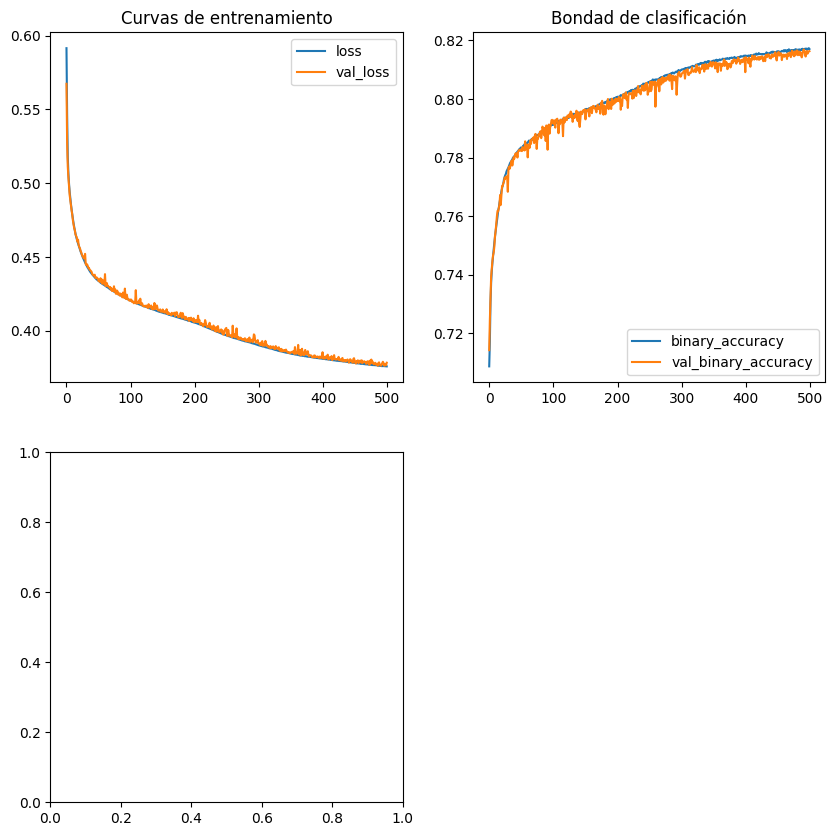

In [23]:
##Convertimos los resultados en un DataFrame y representamos las curvas de aprendizaje y la métrica "binary_accuracy"
history_df = pd.DataFrame(history.history)

#Creamos la figura y la grid donde añadir los graficos
figure = plt.figure(figsize = (10, 10)) #Definimos la figura y su tamaño
grid = gridspec.GridSpec(2, 2, width_ratios = [1, 1]) #Definimos la grid de la figuraa junto con el numero de filas y columnas y el ratio de achos de cada columna

#Añadimos el primer grafico al primer espacio de la cuadricula: Curvas de entrenamiento (función de coste)
ax0 = plt.subplot(grid[0])
history_df.loc[:, ["loss", "val_loss"]].plot(ax = ax0) #Con el argumento de la funcion plot() ax = ax0 indicamos que el grafico correspoda el hueco de la grid asociado a ax0
ax0.set_title('Curvas de entrenamiento')

#Añadimos el segundo grafico al segundo hueco de la cuadricula: Bondad de clasificación
ax1 = plt.subplot(grid[1])
history_df.loc[:, ["binary_accuracy", "val_binary_accuracy"]].plot(ax = ax1)
ax1.set_title("Bondad de clasificación")

#Añadimos el tercer grafico al tercer hueco de la cuadricula: Falsos negativos
ax2 = plt.subplot(grid[2])
history_df.loc[:, ["precision_3", "val_precision_3"]].plot(ax = ax2)
ax2.set_title("Precision")

#Añadimos el cuarto gráfico al cuarto hueco de la cuadricula: Falsos positivos
ax3 = plt.subplot(grid[3])
history_df.loc[:, ["recall_4", "val_recall_4"]].plot(ax = ax3)
ax3.set_title("Recall")

#Mostramos el grafico
plt.tight_layout()  # Ajusta automáticamente los parámetros de la subtrama
plt.show()

In [17]:
##Cargamos el modelo entrenado y congelamos los pesos para que no se puedan modeificcar en posibles procesos de entrenamiento
classifier = load_model("/home/jupyter-manuel/Digiopt/Models/Classifier_NN_HyperModel.keras", custom_objects = {'Classifier_NN': Classifier_NN})
classifier.trainable = False

I0000 00:00:1721373482.616323 1866483 service.cc:145] XLA service 0x7f10a0004900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721373482.616395 1866483 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-07-19 07:18:02.629572: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


   75/17802 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step    

I0000 00:00:1721373482.946247 1866483 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17802/17802 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step


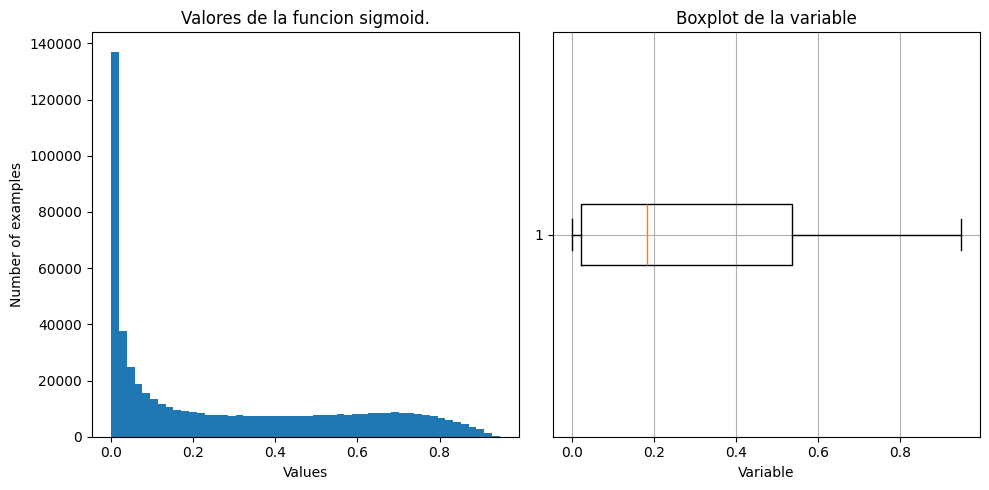

In [18]:
y_predict = classifier.predict(X_train)
#Crear una figura con dos subplots, uno encima del otro
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#Distribución de la variable guardada en la primera neurona
axs[0].hist(y_predict, bins=50)
axs[0].set_title("Valores de la funcion sigmoid.")
axs[0].set_xlabel("Values")
axs[0].set_ylabel("Number of examples")
#Boxplot de la variable guardada en la primera neurona
axs[1].boxplot(y_predict, vert=False)
axs[1].set_title('Boxplot de la variable')
axs[1].set_xlabel('Variable')
axs[1].grid(True)
#Ajustar el layout para evitar superposiciones
plt.tight_layout()
#Mostrar la figura
plt.show()

Genaramos la matriz de confusión para el conjunto de entrenamiento para visualizar los resultados de las predicciones dadas por el modelo.

In [19]:
##Matriz de confusion para el conjunto de entrenamiento
y_predict_train = classifier.predict(X_train)
y_predict_train = (y_predict_train > 0.5).astype(int) #El valor de 0.5 corresponde al umbral
y_predict_train = pd.DataFrame(y_predict_train, index = y_train.index) #Ponemos los indices a las predicciones los correspondientes de la mestra original para que la tabla cruzada se genere correctamente
#Generación de la tabla cruzada
cross_tab = pd.crosstab(y_train, y_predict_train.iloc[:,0], rownames=['Real'], colnames=['Predicción'], margins=True)
print(y_predict_train.iloc[:,0].value_counts())
print(y_train.value_counts())
print(cross_tab)
print("\n")
print_stats(y_predict_train, y_train)

17802/17802 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step
0
0    412798
1    156839
Name: count, dtype: int64
Test_W
0.0    406884
1.0    162753
Name: count, dtype: int64
Predicción       0       1     All
Real                              
0.0         357796   49088  406884
1.0          55002  107751  162753
All         412798  156839  569637


Accuracy: 0.817269594496144
Precision: 0.6870166221411766
Recall: 0.6620523123997715
F1 score: 0.674303486945856


Para una muestra test del conjunto de señales original, y completamente independiente de la muestra de datos empleada para el entrenamiento y validación, realizamos todo el proceso desde el conjunto de datos en bruto hasta obtener los resultados de la clasificación, junto con los diferentes indicadores de la clasificación. Se le aplicara a los datos la reduccion de la dimensión, el test de Wilcoxon y la red neronal de comparación. Esta muestra test no se va a submuestrear.

In [20]:
#Extraemos el conjunto de datos test y lo normalizamos el conjunto de datos test extraido de la muestra completa de señales
core_test = core_signals.iloc[-500:, :]
test_norm = normalizacion(core_test)

#Realizamos el emparejamiento de las señales
start = time.time()
paired_index_test, test_combined = parallel_paired_pulses(test_norm, return_df = True)
end = time.time()
##Determinamos el tiempo de ejecucion
horas, minutos, segundos = convertir_segundos(end - start)
print(f"Tiempo requerido para emparejar las señales: \n {horas} horas, {minutos} minutos, {segundos} segundos")

#Una vez emparejadas las señales procedemos a obtener los resultados del test de Wilcoxon
start = time.time()
test_compared_W = parallel_compare_pulses(test_combined)
end = time.time()
##Determinamos el tiempo de ejecucion
horas, minutos, segundos = convertir_segundos(end - start)
print(f"Tiempo requerido para comparar las señales: \n {horas} horas, {minutos} minutos, {segundos} segundos")
display(test_compared_W.value_counts("Test_W"))

##Extraemos la caracteristica que pretendemos predecir, que en este caso es la evaluacion del test de wilcoxon para pares de señales, que estan contenidas en el DataFrame test_compared_W
test_target_w = test_compared_W["Test_W"]

##Pasamos a reducir la dimensión de las señales que vamos a emplear como muestra en el espacio de dimensión reducida
#En primer lugar convertimos en tensor las señales
test_norm_tf = convert_to_tensor(test_norm)
#Pasamos las señales por el encoder del segundo modelo de autoencoder convolucional para reducir la dimensión de las mismas
encoded_test = tf.squeeze(c_autoencoder_2.encoder(test_norm_tf)).numpy()
#Convertimos las señales reducidas en un DataFrame para trabajar con comodidad con ello
encoded_test_df = pd.DataFrame(encoded_test)

##Llamamos a la función parallel_paired_pulses() para generar todas las posibles combinaciones
start = time.time()
index_paired, test_paired_pulses = parallel_paired_pulses(encoded_test_df, return_df = True)
end = time.time()
#Determinamos el tiempo de ejecución
horas, minutos, segundos = convertir_segundos(end - start)
print(f"Tiempo requerido para emparejar las señales en el espacio de dimension latente: \n {horas} horas, {minutos} minutos, {segundos} segundos")

##Una vez generados los pares de pulsos, añadimos la columna asocada a la comparación dada por el test de Wilcoxon
test_paired_pulses["Test_W"] = test_target_w

##Eliminamos las columnas cuyas neuronas no guardan información, es decir, que todas las filas son cero
#Eliminar columnas donde todas las filas son ceros, generando el DataFrame con el que vamos a trabajar.
df = test_paired_pulses.loc[:, ~(test_paired_pulses == 0).all()]
display(df)

##Generamos los atributos, las etiquetas y los ids para el conjunto de datos test con el que estamos validando la red neuronal
X_test = df.drop(["id_1", "id_2", "Test_W"], axis = 1)
ids_test = df[["id_1", "id_2"]]
y_test = df["Test_W"]

Tiempo requerido para emparejar las señales: 
 0.0 horas, 0.0 minutos, 22.54034447669983 segundos
Tiempo requerido para comparar las señales: 
 0.0 horas, 0.0 minutos, 19.367452383041382 segundos


Test_W
0    111818
1     12932
Name: count, dtype: int64

Tiempo requerido para emparejar las señales en el espacio de dimension latente: 
 0.0 horas, 0.0 minutos, 9.813018083572388 segundos


,id_1,id_2,1,4,8,11,14,18,Test_W
0,0,1,1.420311,1.160016,1.478657,1.692396,1.003889,0.634027,0
1,0,2,1.420311,1.160016,1.478657,1.196918,1.243660,1.602770,1
2,0,3,1.420311,1.160016,1.478657,1.188252,1.243663,2.409366,0
3,0,4,1.420311,1.160016,1.478657,2.407470,0.621778,0.478718,0
4,0,5,1.420311,1.160016,1.478657,1.159481,0.775126,3.009976,0
...,...,...,...,...,...,...,...,...,...
124745,496,498,1.748392,1.157385,1.830182,1.328869,1.430309,1.773226,0
124746,496,499,1.748392,1.157385,1.830182,1.181741,1.276081,1.724730,0
124747,497,498,1.157118,1.416851,1.698095,1.328869,1.430309,1.773226,0
124748,497,499,1.157118,1.416851,1.698095,1.181741,1.276081,1.724730,1


In [21]:
##Calculamos las predicciones del modelo dadas para el conjunto de datos test
y_predict_test = classifier.predict(X_test)
y_predict_test = (y_predict_test > 0.5).astype(int)
#Convertimos las predicciones a un DataFrame y mostramos los resultados obtenidos
y_predict_test = pd.DataFrame(y_predict_test, index = y_test.index)
display(y_predict_test.value_counts())
display(y_test.value_counts())

##Generación de la tabla cruzada
cross_tab = pd.crosstab(y_test, y_predict_test.iloc[:,0], rownames=['Real'], colnames=['Predicción'], margins=True)
print(cross_tab)

#Llamamos a la funcion para calular las stats de la clasificación
print("\n")
print_stats(y_predict_test, y_test)

3899/3899 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


0
0    103118
1     21632
Name: count, dtype: int64

Test_W
0    111818
1     12932
Name: count, dtype: int64

Predicción       0      1     All
Real                             
0            98557  13261  111818
1             4561   8371   12932
All         103118  21632  124750


Accuracy: 0.8571382765531063
Precision: 0.3869730029585799
Recall: 0.6473090009279308
F1 score: 0.48437680823978707


Calculamos la curva ROC como métrica de clasificación del modelo para poder comparar el desempeño de la red neuronal a la hora de clasificar, de tal manera que podamos comparar los resultados entre modelos.

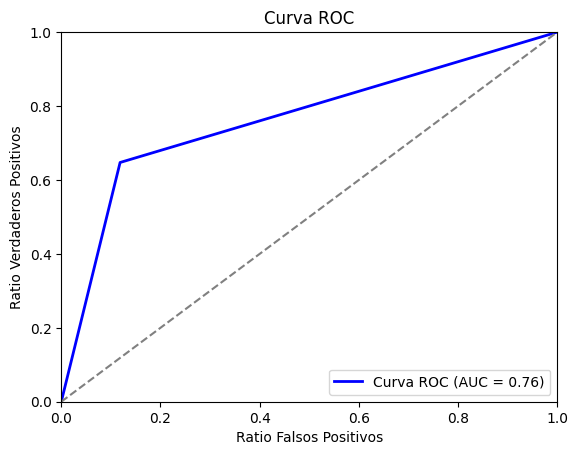

In [22]:
#Calcular los puntos de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_predict_test)

#Calcular el AUC
auc = roc_auc_score(y_test, y_predict_test)

#Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color = 'blue', lw = 2, label = 'Curva ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color = 'gray', linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Ratio Falsos Positivos')
plt.ylabel('Ratio Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc = "lower right")
plt.show()

Generamos la imagen correspondientes a la arquitectura del modelo de clasificación usado.

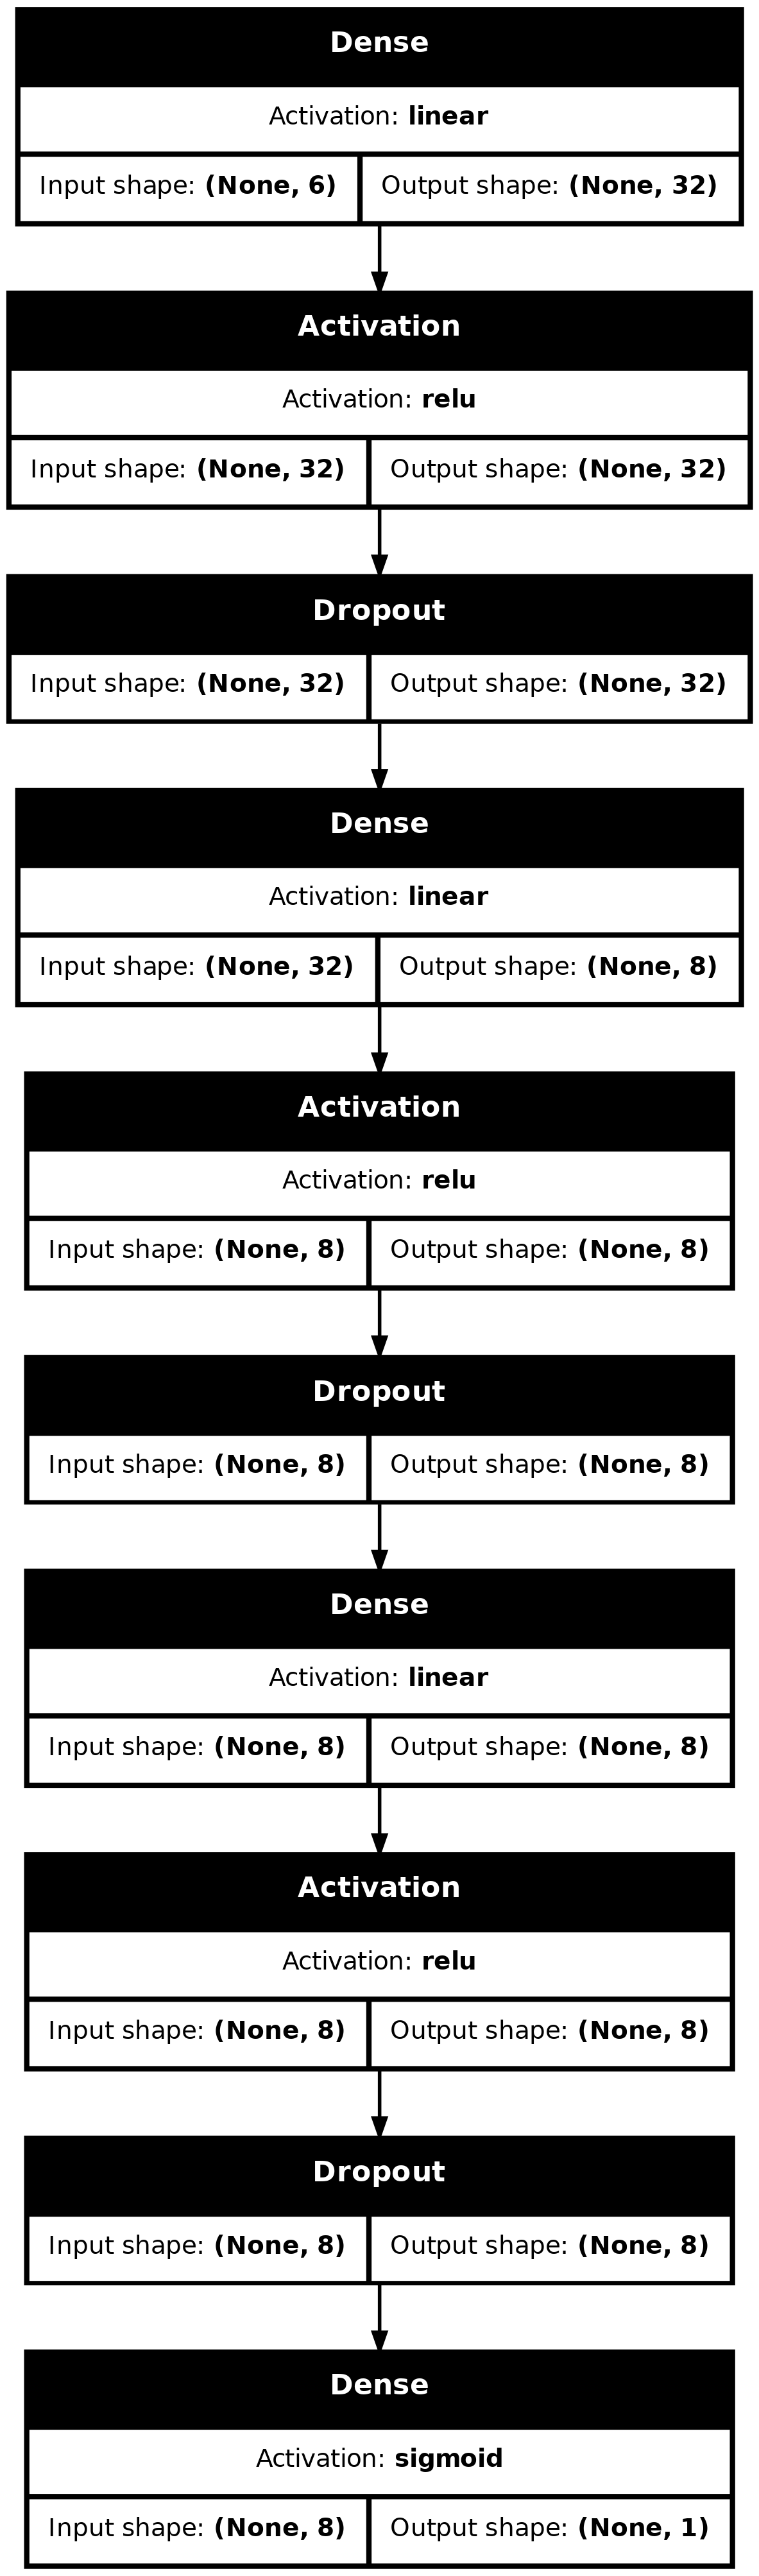

In [22]:
#Generacion de graficos de arquitecturas
import graphviz
import pydotplus
#Generacion del grafico en un fichero
#Arqutectura encoder
plot_model(classifier.classifier, to_file='/home/jupyter-manuel/Digiopt/Imagenes_arquitecturas/Classifier_NN_2.png', show_shapes = True, show_layer_activations = True)

#Mostrar la imagen del gráfico
Image(filename='/home/jupyter-manuel/Digiopt/Imagenes_arquitecturas/Classifier_NN_2.png')

Se cierra la sesión abierta de Tensorflow de tal manera que se libere el espacio de memoria de la GPU reservado.

In [23]:
##Ejecutar siempre que se quiera liberar el espacio de la GPU y al final de cada scrip
cuda.select_device(0)
cuda.close()